# Direction Calculator Notebook

This notebook demonstrates how to calculate reasoning directions by comparing activations between RL-trained and distilled models.

In [1]:
import sys
import os
sys.path.append('../pipeline')

# Set HuggingFace cache directory to scratch to avoid home directory out of memory
os.environ['HF_HOME'] = '/scratch/gilbreth/sramishe'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/gilbreth/sramishe/transformers'
os.environ['HF_DATASETS_CACHE'] = '/scratch/gilbreth/sramishe/datasets'

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model_loader import ModelLoader
from data_processor import DataProcessor
from direction_calculator import DirectionCalculator

print(f"HuggingFace cache directory set to: {os.environ['HF_HOME']}")

/home/sramishe/.venv llm-env/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sramishe/.venv llm-env/lib64/python3.9/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


HuggingFace cache directory set to: /scratch/gilbreth/sramishe


## Setup: Load Models and Data

In [2]:
# Load models
loader = ModelLoader()
models = loader.load_models(torch_dtype=torch.float16)

rl_model = models['rl_model']
rl_tokenizer = models['rl_tokenizer']
distilled_model = models['distilled_model']
distilled_tokenizer = models['distilled_tokenizer']

Loading RL-trained model: Qwen/QwQ-32B-Preview


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]


Loading distilled model: deepseek-ai/DeepSeek-R1-Distill-Qwen-32B


Loading checkpoint shards: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


In [3]:
# Load data
processor = DataProcessor()
dataset = processor.load_dataset(max_samples=10)
toy_tasks = processor.get_toy_tasks()

# Prepare prompts
all_examples = dataset[:5] + toy_tasks[:3]
prompts = processor.prepare_batch(all_examples, rl_tokenizer)

print(f"Prepared {len(prompts)} prompts")

Loading dataset: HuggingFaceH4/MATH-500


Generating test split: 100%|██████████| 500/500 [00:00<00:00, 6187.09 examples/s]

Prepared 8 prompts


## Initialize Direction Calculator

In [4]:
calculator = DirectionCalculator()

## Capture Activations from Both Models

In [5]:
# Define layers to analyze (sample every 5th layer)
model_info = loader.get_model_info()
num_layers = model_info['rl_model']['num_layers']
layers_to_analyze = list(range(0, num_layers, 5))

print(f"Analyzing layers: {layers_to_analyze}")

Analyzing layers: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]


In [6]:
# Capture RL model activations
print("Capturing RL model activations...")
rl_activations = calculator.capture_activations(
    rl_model,
    rl_tokenizer,
    prompts[:3],  # Use subset for speed
    layers_to_analyze
)

print(f"Captured activations for {len(rl_activations)} layers")

Capturing RL model activations...
Captured activations for 13 layers


In [7]:
# Capture distilled model activations
print("Capturing distilled model activations...")
distilled_activations = calculator.capture_activations(
    distilled_model,
    distilled_tokenizer,
    prompts[:3],
    layers_to_analyze
)

print(f"Captured activations for {len(distilled_activations)} layers")

Capturing distilled model activations...
Captured activations for 13 layers


## Calculate Reasoning Directions

In [8]:
directions = calculator.calculate_direction(
    rl_activations,
    distilled_activations,
    normalize_output=True
)

print(f"Computed directions for {len(directions)} layers")

Computed directions for 13 layers


## Analyze Direction Statistics

In [9]:
stats = calculator.compute_direction_stats()

print("Direction Statistics:")
for layer, layer_stats in stats.items():
    print(f"\nLayer {layer}:")
    for key, value in layer_stats.items():
        print(f"  {key}: {value:.6f}")

Direction Statistics:

Layer 0:
  norm: 1.000000
  mean: -0.000166
  std: 0.013977
  max: 0.304932
  min: -0.420166

Layer 5:
  norm: 0.999512
  mean: 0.000059
  std: 0.013969
  max: 0.579590
  min: -0.588867

Layer 10:
  norm: 1.000000
  mean: 0.000054
  std: 0.013977
  max: 0.584961
  min: -0.607910

Layer 15:
  norm: 1.000000
  mean: 0.000111
  std: 0.013977
  max: 0.583496
  min: -0.598633

Layer 20:
  norm: 1.000000
  mean: 0.000157
  std: 0.013977
  max: 0.591309
  min: -0.612793

Layer 25:
  norm: 1.000000
  mean: 0.000074
  std: 0.013977
  max: 0.591309
  min: -0.604980

Layer 30:
  norm: 1.000000
  mean: 0.000090
  std: 0.013977
  max: 0.597168
  min: -0.588379

Layer 35:
  norm: 1.000000
  mean: 0.000067
  std: 0.013977
  max: 0.595703
  min: -0.569824

Layer 40:
  norm: 0.999512
  mean: 0.000036
  std: 0.013969
  max: 0.596680
  min: -0.585938

Layer 45:
  norm: 1.000000
  mean: 0.000018
  std: 0.013977
  max: 0.605957
  min: -0.586914

Layer 50:
  norm: 0.999512
  mean: 0.0

## Visualize Direction Norms Across Layers

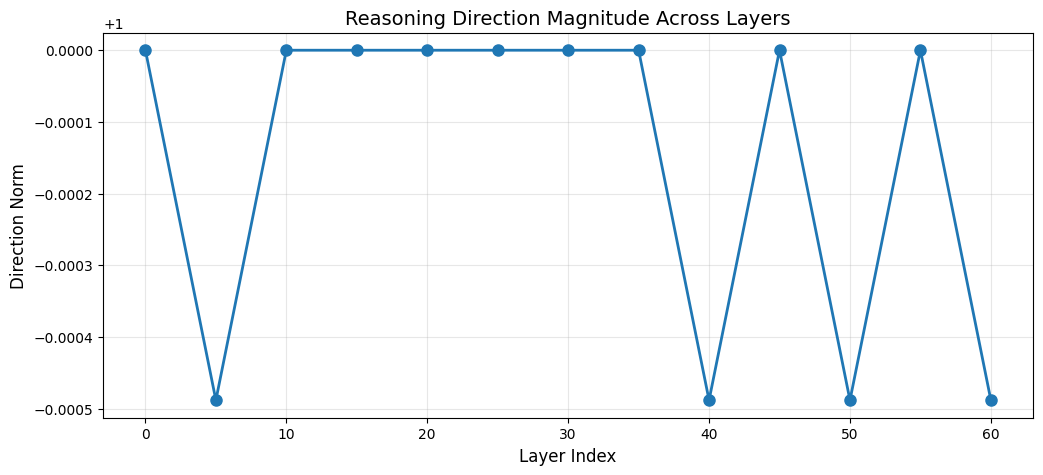

In [10]:
layers = sorted(stats.keys())
norms = [stats[layer]['norm'] for layer in layers]

plt.figure(figsize=(12, 5))
plt.plot(layers, norms, marker='o', linewidth=2, markersize=8)
plt.xlabel('Layer Index', fontsize=12)
plt.ylabel('Direction Norm', fontsize=12)
plt.title('Reasoning Direction Magnitude Across Layers', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

## Visualize Direction Statistics Heatmap

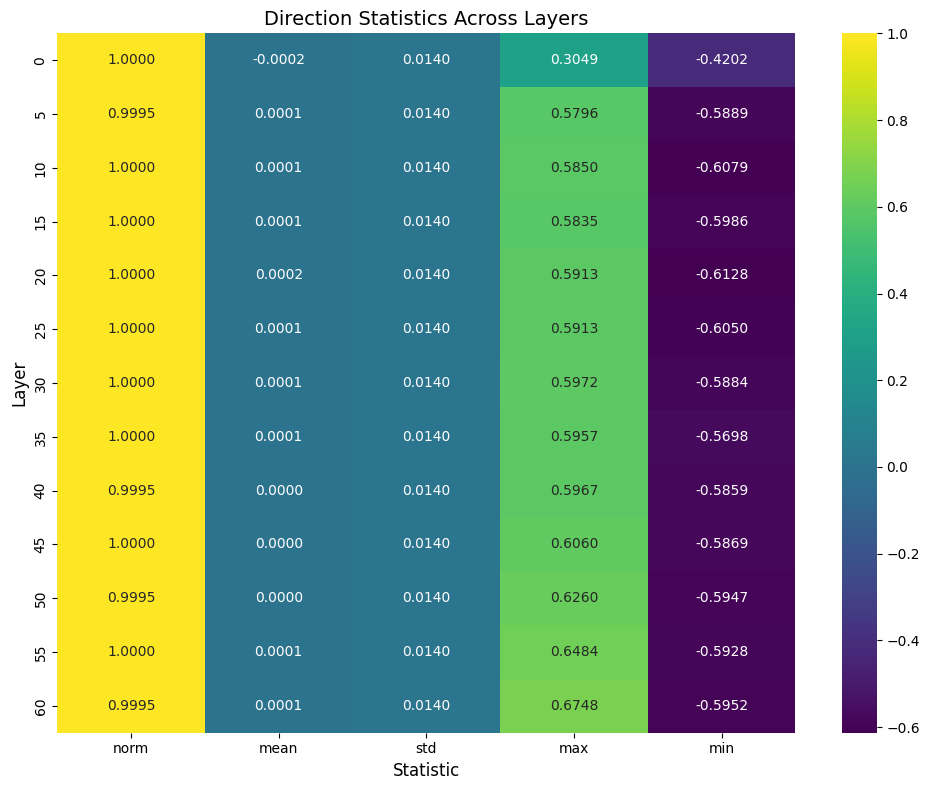

In [11]:
# Create matrix for heatmap
stat_names = ['norm', 'mean', 'std', 'max', 'min']
stat_matrix = np.array([[stats[layer][stat] for stat in stat_names] for layer in layers])

plt.figure(figsize=(10, 8))
sns.heatmap(stat_matrix, 
            xticklabels=stat_names, 
            yticklabels=layers,
            cmap='viridis',
            annot=True,
            fmt='.4f')
plt.xlabel('Statistic', fontsize=12)
plt.ylabel('Layer', fontsize=12)
plt.title('Direction Statistics Across Layers', fontsize=14)
plt.tight_layout()
plt.show()

## Save and Load Directions

In [13]:
# Save directions
calculator.save_directions('/scratch/gilbreth/sramishe/results_QwQ_R1/results/reasoning_directions.pt')

# Load directions (demo)
# calculator_new = DirectionCalculator()
# calculator_new.load_directions('../results/reasoning_directions.pt')

Directions saved to /scratch/gilbreth/sramishe/results_QwQ_R1/results/reasoning_directions.pt


## Inspect Individual Direction Vectors

In [14]:
# Get direction for a specific layer
layer_idx = layers[0]
direction = calculator.get_direction(layer_idx)

print(f"Direction for layer {layer_idx}:")
print(f"Shape: {direction.shape}")
print(f"First 10 values: {direction.squeeze()[:10]}")

Direction for layer 0:
Shape: torch.Size([1, 5120])
First 10 values: tensor([-0.0006,  0.0003, -0.0004, -0.0052,  0.0030, -0.0023,  0.0053, -0.0007,
         0.0011, -0.0109], device='cuda:0', dtype=torch.float16)
